In [ ]:

# Importing libraries 

import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import json 
import re
from nltk import word_tokenize

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Datasets/data.csv")

In [ ]:
data.head()

,data,label
0,ABC XYZ – CHANGE OF ADDRESS Pension reference ...,MDU
1,"Address change former employee DEF Hi Team, Pl...",MDU
2,Change of Address – ABC XYZ NINO ZZ123123Z DOB...,MDU
3,Change of address Good evening Is it possible ...,MDU
4,"Change of address Good morning, I have a pensi...",MDU


In [ ]:
data.shape

(277, 2)

In [ ]:
#Now lets split the data
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, shuffle = True, stratify = data.label, train_size = 0.8, random_state = 50)

train.shape, test.shape

((221, 2), (56, 2))

In [ ]:
train.to_csv('/content/drive/MyDrive/Datasets/train.csv', index = False)
test.to_csv('/content/drive/MyDrive/Datasets/test.csv', index = False)

In [ ]:
# Adverserial Validation
from scipy import sparse
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold


def adversarial_validation(X, Y, n_splits = 10):
    
    # Combine both datasets
    sparse_merge = sparse.vstack((X, Y))
    
    # Label the datasets
    y = np.array([0 for _ in range(X.shape[0])] + [1 for _ in range(Y.shape[0])])
    
    # Do 10 Fold CV 
    kfold = StratifiedKFold(n_splits = n_splits, shuffle = True)

    lr_auc = np.array([])
    rf_auc = np.array([])
    for train_idx, test_idx in kfold.split(sparse_merge, y):
    
        #Run Log Reg
        x_train, y_train = sparse_merge[train_idx], y[train_idx]
        x_test, y_test = sparse_merge[test_idx], y[test_idx]
        
        log_reg = SGDClassifier(loss = 'log')
        log_reg.fit(x_train, y_train)
        y_test_prob = log_reg.predict_proba(x_test)[:,1]
        lr_auc = np.append(lr_auc, roc_auc_score(y_test, y_test_prob))
        # Run RF
        rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1)
        rf.fit(x_train, y_train)
        y_test_prob = rf.predict_proba(x_test)[:,1]
        rf_auc = np.append(rf_auc, roc_auc_score(y_test, y_test_prob))

    
    # Display results
    print('Logisitic Regression AUC : {:.3f}'.format(lr_auc.mean()))
    print('Random Forest AUC : {:.3f}'.format(rf_auc.mean()))

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle 

bow = CountVectorizer()
x_train = bow.fit_transform(train.data.values)
x_test = bow.transform(test.data.values)

x_test = shuffle(x_test)

adversarial_validation(x_train, x_test[:50])

Logisitic Regression AUC : 0.413
Random Forest AUC : 0.358


In [ ]:
data['label'].value_counts()

Transfers      98
retirements    94
MDU            85
Name: label, dtype: int64

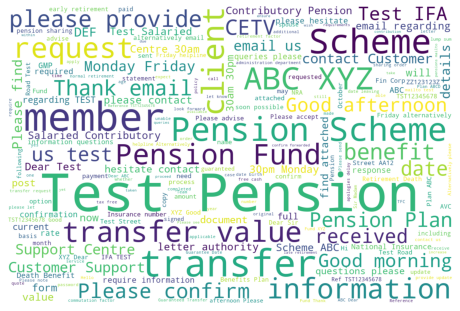

In [ ]:
%matplotlib inline
from wordcloud import WordCloud 
import matplotlib.pyplot as plt


wordcloud = WordCloud(width = 1200, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(' '.join(train[train.label == 'Transfers'].data.values)) 

plt.figure(figsize = (8,8))
                      
plt.imshow(wordcloud) 
plt.axis("off") 
#plt.tight_layout(pad = 0) 
  
plt.show()

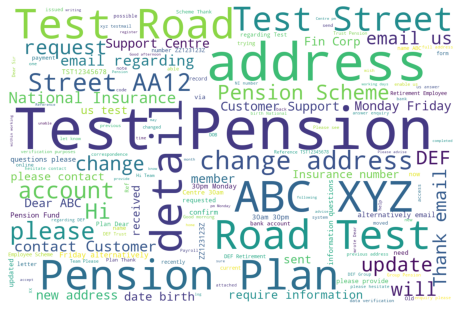

In [ ]:
%matplotlib inline
from wordcloud import WordCloud 
import matplotlib.pyplot as plt


wordcloud = WordCloud(width = 1200, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(' '.join(train[train.label == 'MDU'].data.values)) 

plt.figure(figsize = (8,8))
plt.imshow(wordcloud) 
plt.axis("off") 
#plt.tight_layout(pad = 0) 
  
plt.show()

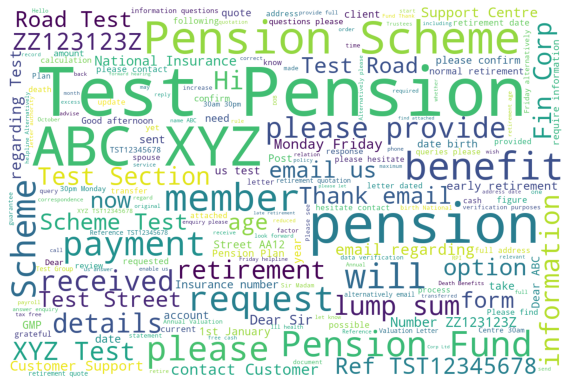

In [ ]:
%matplotlib inline
from wordcloud import WordCloud 
import matplotlib.pyplot as plt


wordcloud = WordCloud(width = 1200, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(' '.join(train[train.label == 'retirements'].data.values)) 

plt.figure(figsize = (10,8))
                      
plt.imshow(wordcloud) 
plt.axis("off") 
#plt.tight_layout(pad = 0) 
  
plt.show()

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

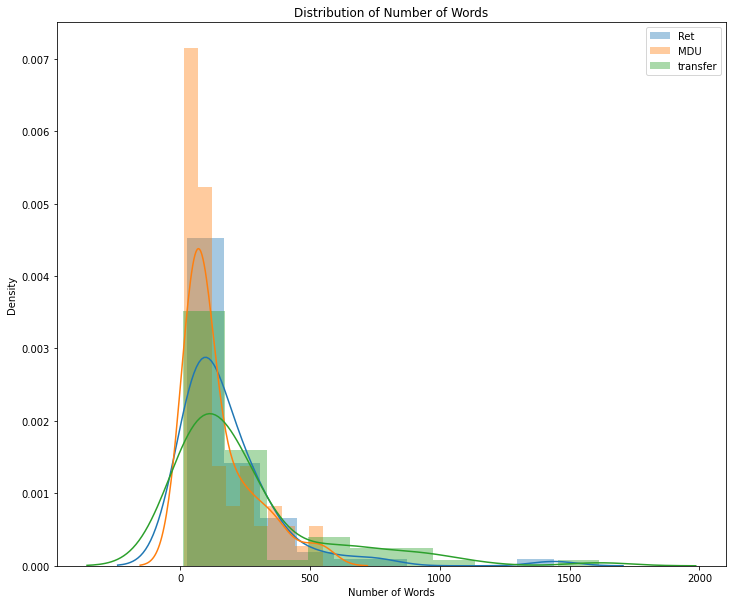

In [ ]:
# What is the effect of number of words ? 
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (12,10))

Ret = [len(word_tokenize(title)) for title in train[train.label.values == 'retirements'].data.values]
MDU = [len(word_tokenize(title)) for title in train[train.label.values == 'MDU'].data.values]
transfer = [len(word_tokenize(title)) for title in train[train.label.values == 'Transfers'].data.values]
sns.distplot(Ret, bins = 10, label = 'Ret')
sns.distplot(MDU, bins = 10, label = 'MDU')
sns.distplot(transfer, bins = 10, label = 'transfer')
plt.legend()
plt.title('Distribution of Number of Words')
plt.xlabel('Number of Words')
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
MDU Mean: 0.286
Ret Mean: 0.315
transfer: 0.319


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

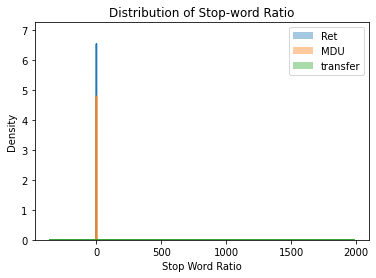

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
    
    
def stop_words_ratio(x):
    num_total_words = 0
    num_stop_words = 0
    for word in word_tokenize(x):
        if word in stop_words:
            num_stop_words += 1
        num_total_words += 1 
    return num_stop_words/num_total_words


Ret =  train[train.label.values == 'retirements'].data.apply(stop_words_ratio)
MDU =  train[train.label.values == 'MDU'].data.apply(stop_words_ratio)
Transfers =  train[train.label.values == 'Transfers'].data.apply(stop_words_ratio)

sns.distplot(Ret, norm_hist = True, label = 'Ret')
sns.distplot(MDU,  label = 'MDU')
sns.distplot(transfer, label = 'transfer')

print('MDU Mean: {:.3f}'.format(MDU.values.mean()))
print('Ret Mean: {:.3f}'.format(Ret.values.mean()))
print('transfer: {:.3f}'.format(Transfers.values.mean()))
plt.title('Distribution of Stop-word Ratio')
plt.xlabel('Stop Word Ratio')
plt.legend()